In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import learning_curve, StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, make_scorer, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
import optuna
from models.manage_models import save_model

In [2]:
f1_macro = make_scorer(f1_score, average="macro")

In [3]:
df = pd.read_csv("dataset/gas_turbine_fault_detection_simulated3.csv")  # ajusta ruta/nombre

df_fault = df[df["Fault"] == 1].copy()

cols_drop = ["Turbine ID", "TTC", "Fault", "Fault Mode"]  # ajusta nombres exactos
X = df_fault.drop(columns=cols_drop)
y = df_fault["Fault Mode"]  # multiclase

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [ ]:
def objective(trial):
    scaler_name = trial.suggest_categorical('scaler', ['standard', 'robust', 'minmax'])
    if scaler_name == 'standard':
        scaler = StandardScaler()
    elif scaler_name == 'robust':
        scaler = RobustScaler()
    else:
        scaler = MinMaxScaler()

    kernel = trial.suggest_categorical('kernel', ['rbf', 'sigmoid'])
    
    C = trial.suggest_float('C', 1e-4, 1e3, log=True)
    
    gamma = trial.suggest_float('gamma', 1e-5, 10, log=True)

    params = {
        'kernel': kernel,
        'C': C,
        'gamma': gamma,
        'class_weight': 'balanced',
        'cache_size': 2000, 
        'random_state': 42
    }
    
    if kernel == 'sigmoid':
        params['coef0'] = trial.suggest_float('coef0', -10.0, 10.0)

    model = SVC(**params)

    pipeline = Pipeline([
        ('scaler', scaler),
        ('model', model)
    ])

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    scores = cross_val_score(pipeline, X_train, y_train, n_jobs=-1, cv=cv, scoring=f1_macro)
    
    return scores.mean()

In [5]:
study = optuna.create_study(direction="maximize", study_name='svm_opt')
study.optimize(objective, n_trials=100, show_progress_bar=True) 

print(f"Mejor score (f1_macro): {study.best_value}")
print(f"Mejores parámetros: {study.best_params}")

[I 2025-12-27 08:15:05,257] A new study created in memory with name: svm_opt


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-27 08:15:11,607] Trial 0 finished with value: 0.9427731241670976 and parameters: {'scaler': 'standard', 'kernel': 'rbf', 'C': 1.0615286152784056, 'gamma': 0.0012033527818853084}. Best is trial 0 with value: 0.9427731241670976.
[I 2025-12-27 08:15:39,314] Trial 1 finished with value: 0.3144104700879783 and parameters: {'scaler': 'robust', 'kernel': 'sigmoid', 'C': 0.03324308731907601, 'gamma': 0.06645015525981693, 'coef0': 6.548596281393692}. Best is trial 0 with value: 0.9427731241670976.
[I 2025-12-27 08:16:11,820] Trial 2 finished with value: 0.29597874062007307 and parameters: {'scaler': 'robust', 'kernel': 'rbf', 'C': 0.00077758911265024, 'gamma': 0.004915412940259794}. Best is trial 0 with value: 0.9427731241670976.
[I 2025-12-27 08:16:57,556] Trial 3 finished with value: 0.16617222476007373 and parameters: {'scaler': 'minmax', 'kernel': 'sigmoid', 'C': 14.771411767706372, 'gamma': 0.14735226686173625, 'coef0': -9.353845617482513}. Best is trial 0 with value: 0.94277312

In [6]:
optuna.visualization.plot_optimization_history(study)

In [7]:
optuna.visualization.plot_param_importances(study)

In [8]:
optuna.visualization.plot_contour(study, params=["kernel", "gamma"])

In [9]:
params = study.best_params.copy()
scaler = params.pop('scaler')

scaler

'standard'

In [10]:
final_model = SVC(**params, 
                  random_state=42, 
                  class_weight='balanced', 
                  cache_size=2000, 
                  tol=1e-3)

In [11]:
final_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', final_model)
])

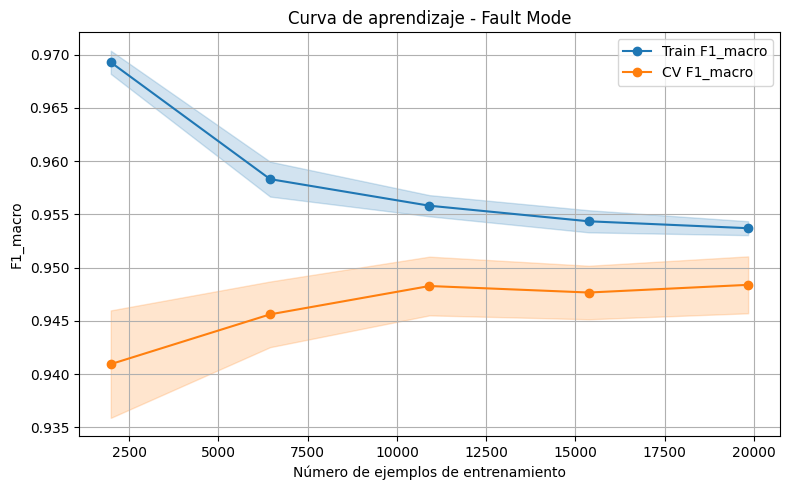

In [12]:
train_sizes, train_scores, val_scores = learning_curve(
    estimator=final_pipeline,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 5),  # 10%, 32.5%, ..., 100%
    cv=5,
    scoring=f1_macro,
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, "o-", color="tab:blue", label="Train F1_macro")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std,
                 alpha=0.2, color="tab:blue")
plt.plot(train_sizes, val_mean, "o-", color="tab:orange", label="CV F1_macro")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std,
                 alpha=0.2, color="tab:orange")
plt.xlabel("Número de ejemplos de entrenamiento")
plt.ylabel("F1_macro")
plt.title("Curva de aprendizaje - Fault Mode")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()